In [2]:
import numpy as np

In [69]:

# Define program constants
n_points = 150000

# Initialize Arrays
shaper_thickness = np.zeros(n_points) # mm 
shaper_eng_strain = np.zeros(n_points) # mm/mm
time = np.zeros(n_points) # ms
delta_t = np.zeros(n_points) # ms
incident_eng_strain = np.zeros(n_points)
incident_eng_stress = np.zeros(n_points)
strain_rate = np.zeros(n_points) #1/ms
v1 = np.zeros(n_points) # velocity of the striker bar after the incident wave interacts with pulse shaper 
v2 = np.zeros(n_points) # velocity of the incident wave

# Pulse Shaper Material Properties
shaper_yield_strength = 0.750 # GPa
shaper_elastic_modulus = 117.21 # GPa
shaper_strain_hardening_exponent = 0.37
shaper_strain_rate_exponent = 4.25

#Initial Conditions
shaper_initial_thickness = 4.0 # mm
shaper_initial_diameter = 4.0 # mm
shaper_initial_cross = (shaper_initial_diameter**2) * (np.pi/4) # mm^2
shaper_deformation_step = 0.0005 # mm 
n_steps = 50

# Bar Properties
bar_elastic_modulus = 200 # GPa
bar_density = 8.1e-6 # kg/mm^3
bar_wave_speed = 4969 # mm / ms 
bar_diameter = 9.525 # mm 
bar_cross = (np.pi / 4) * bar_diameter**2 # mm^2

# Striker properties
striker_velocity = 12.28 # m/s 
striker_length = 304.8 # mm 
striker_wave_rise_time = (2*striker_length) / bar_wave_speed # ms

# Define step sizes
star1 = shaper_deformation_step / 200
star2 = shaper_deformation_step / 10000
star3 = shaper_deformation_step / 52500
star4 = shaper_deformation_step / 25000

# Scaling factors
Ak = ((shaper_yield_strength*shaper_initial_cross) / (striker_velocity*bar_cross)) * ((1/(bar_wave_speed * bar_density)) \
                                                                                      + (1 / (bar_wave_speed * bar_density)))    
Ak_1 = (2*shaper_yield_strength*shaper_initial_cross) / (bar_density * bar_wave_speed * striker_velocity * bar_cross)

# Initial values
shaper_thickness[0] = shaper_initial_thickness 
v1[0] = striker_velocity
strain_rate[0] = striker_velocity / shaper_inital_thickness

sigma_max = (0.99 * 0.5 * bar_density * bar_wave_speed * striker_velocity) * 1000 # MPa
count = 1 

In [70]:
def wave_pass(n_prev_final, pass_number):
    """
    Simulates a wave pass in the SHPB system.
    
    Parameters:
    - n_prev_final: The last index from the previous wave pass.
    - pass_number: The current wave pass number (1st, 2nd, etc.).
    
    Returns:
    - The final index (n_final) where the strain rate becomes zero.
    """
    print(f"Starting wave pass {pass_number}...")

    n_final = n_points - 1  # Default value in case loop does not exit early

    for i in range(n_prev_final + 1, n_points):
        # Step 1: Compute new thickness (reduce thickness due to wave interaction)
        new_thickness = shaper_thickness[i - 1] - star1
        shaper_thickness[i] = new_thickness

        # Step 2: Compute strain in the pulse shaper
        shaper_eng_strain[i] = (shaper_initial_thickness - new_thickness) / shaper_initial_thickness

        # Step 3: Compute time increment with interaction
        denominator = 1.0 - Ak * (shaper_eng_strain[i] ** shaper_strain_hardening_exponent) / (
                        (1.0 - shaper_eng_strain[i] ** shaper_strain_rate_exponent) * (1.0 - shaper_eng_strain[i]))

        # Include reflections from previous passes ONLY if pass_number > 1
        if pass_number > 1:
            for j in range(pass_number - 1):  # Access only completed wave passes
                if i - wave_final_steps[j] > 0:
                    denominator -= Ak_1 * (shaper_eng_strain[i - wave_final_steps[j]] ** shaper_strain_hardening_exponent) / (
                                  (1.0 - shaper_eng_strain[i - wave_final_steps[j]] ** shaper_strain_rate_exponent) * 
                                  (1.0 + shaper_eng_strain[i - wave_final_steps[j]]))

        # Compute delta time
        delta_t[i] = (shaper_initial_thickness / striker_velocity) * (1.0 / denominator) * \
                     (shaper_eng_strain[i] - shaper_eng_strain[i - 1]) + time[i - 1]

        # Step 4: Compute the incident strain
        incident_eng_strain[i] = (shaper_yield_strength * shaper_initial_cross) / (bar_elastic_modulus * bar_cross) * \
                                 (shaper_eng_strain[i] ** shaper_strain_hardening_exponent) / \
                                 ((1.0 + shaper_eng_strain[i] ** shaper_strain_rate_exponent) * (1.0 - shaper_eng_strain[i]))

        # Step 5: Compute the incident stress
        incident_eng_stress[i] = incident_eng_strain[i] * (bar_elastic_modulus * 1e3)  # Convert GPa to MPa

        # Step 6: Ensure stress does not exceed maximum threshold
        if incident_eng_stress[i] >= sigma_max:
            incident_eng_stress[i] = sigma_max
            incident_eng_strain[i] = incident_eng_stress[i] / (bar_elastic_modulus * 1e3)
            shaper_thickness[i] = shaper_thickness[i - 1]
            shaper_eng_strain[i] = shaper_eng_strain[i - 1]

        # Step 7: Compute new velocities
        v1[i] = striker_velocity - (incident_eng_stress[i] * 1e6) / (bar_density * bar_wave_speed)
        v2[i] = (incident_eng_stress[i] * 1e6) / (bar_density * bar_wave_speed)

        # Step 8: Compute strain rate
        strain_rate[i] = (v1[i] - v2[i]) / shaper_initial_thickness

        # Step 9: Store time step
        time[i] = delta_t[i]

        # Step 10: Stop if strain rate is near zero
        if strain_rate[i] <= 0.0:
            strain_rate[i] = 0.0
            n_final = i  # Store last valid index
            break

    print(f"Wave pass {pass_number} complete. Final step: {n_final}, Final time: {time[n_final]:.6f} ms")
    return n_final  # Return final step for the next pass


In [71]:
# Store final steps of each wave pass
wave_final_steps = []

# First wave pass
n_final_1 = wave_pass(0, 1)
wave_final_steps.append(n_final_1)

# Second wave pass
n_final_2 = wave_pass(n_final_1, 2)
wave_final_steps.append(n_final_2)

# Third wave pass
n_final_3 = wave_pass(n_final_2, 3)
wave_final_steps.append(n_final_3)

# Fourth wave pass
n_final_4 = wave_pass(n_final_3, 4)
wave_final_steps.append(n_final_4)

# Fifth wave pass
n_final_5 = wave_pass(n_final_4, 5)
wave_final_steps.append(n_final_5)

# Sixth wave pass
n_final_6 = wave_pass(n_final_5, 6)
wave_final_steps.append(n_final_6)


Starting wave pass 1...
Wave pass 1 complete. Final step: 1, Final time: 0.000000 ms
Starting wave pass 2...
Wave pass 2 complete. Final step: 2, Final time: 0.000000 ms
Starting wave pass 3...
Wave pass 3 complete. Final step: 3, Final time: 0.000001 ms
Starting wave pass 4...
Wave pass 4 complete. Final step: 4, Final time: 0.000001 ms
Starting wave pass 5...
Wave pass 5 complete. Final step: 5, Final time: 0.000001 ms
Starting wave pass 6...
Wave pass 6 complete. Final step: 6, Final time: 0.000001 ms


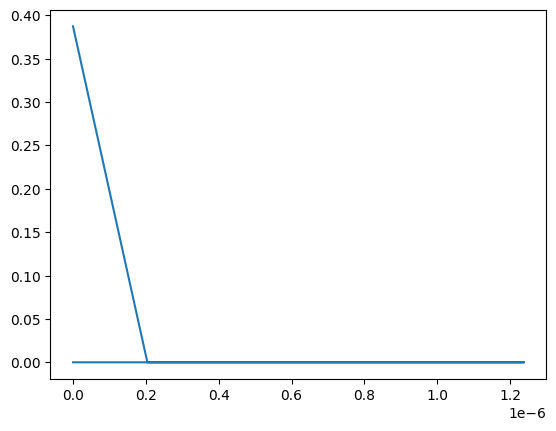

In [72]:
plt.plot(time, strain_rate)